In [87]:
#https://www.annytab.com/dynamic-bayesian-network-in-python/

In [10]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.feature_selection import RFE

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [11]:
df = pd.read_csv('preprocessed_data_predict_current_year.csv')
df['timeslice'] = 1
df.head()

,Unnamed: 0,project_patient_id,window_id,window_start,window_train_breakpoint,window_end,contact_encounter_frequency,office_encounter_frequency,outpatient_procedure_encounter_frequency,psych_comorbidity,...,race,ethnic_group,is_alive,grand_max_date,grand_min_date,grand_timespan,age_le,marital_status_le,employment_status_le,timeslice
0,0,4d3ea8f4-15b6-477f-805e-7932c6aabc74,0,2014-06-15 18:00:00,2015-06-16 00:00:00,2015-06-16 00:00:00,2.0,2.0,0.0,0.0,...,-1,-1,0,2015-06-16 00:00:00,2011-04-05 00:00:00,1533 days,1,3,6,1
1,1,4d3ea8f4-15b6-477f-805e-7932c6aabc74,1,2013-06-15 12:00:00,2014-06-15 18:00:00,2014-06-15 18:00:00,2.0,2.0,0.0,0.0,...,-1,-1,0,2015-06-16 00:00:00,2011-04-05 00:00:00,1533 days,1,3,6,1
2,2,4d3ea8f4-15b6-477f-805e-7932c6aabc74,2,2012-06-15 06:00:00,2013-06-15 12:00:00,2013-06-15 12:00:00,2.0,0.0,0.0,0.0,...,-1,-1,0,2015-06-16 00:00:00,2011-04-05 00:00:00,1533 days,1,3,6,1
3,3,dba8cd2e-1a6c-49a3-8d84-e95c58edf52d,0,2016-05-26 18:00:00,2017-05-27 00:00:00,2017-05-27 00:00:00,0.0,0.0,0.0,0.0,...,-1,-1,0,2017-05-27 00:00:00,2009-06-26 00:00:00,2892 days,3,3,6,1
4,4,dba8cd2e-1a6c-49a3-8d84-e95c58edf52d,1,2015-05-27 12:00:00,2016-05-26 18:00:00,2016-05-26 18:00:00,0.0,0.0,0.0,0.0,...,-1,-1,0,2017-05-27 00:00:00,2009-06-26 00:00:00,2892 days,3,3,6,1


In [12]:
df.shape

(9595, 37)

In [13]:
# Unique patients
len(df['project_patient_id'].unique())

1625

In [14]:
# Create a sequence number representing individual timeslices for each patient
for p_id in df['project_patient_id'].unique():
    temp = df.query('project_patient_id == "' + p_id + '"').sort_values('window_start')
    cnt = 1
    for idx, row in temp.iterrows():
        df.at[idx, 'timeslice'] = cnt
        cnt+=1

In [15]:
df.head()

,Unnamed: 0,project_patient_id,window_id,window_start,window_train_breakpoint,window_end,contact_encounter_frequency,office_encounter_frequency,outpatient_procedure_encounter_frequency,psych_comorbidity,...,race,ethnic_group,is_alive,grand_max_date,grand_min_date,grand_timespan,age_le,marital_status_le,employment_status_le,timeslice
0,0,4d3ea8f4-15b6-477f-805e-7932c6aabc74,0,2014-06-15 18:00:00,2015-06-16 00:00:00,2015-06-16 00:00:00,2.0,2.0,0.0,0.0,...,-1,-1,0,2015-06-16 00:00:00,2011-04-05 00:00:00,1533 days,1,3,6,3
1,1,4d3ea8f4-15b6-477f-805e-7932c6aabc74,1,2013-06-15 12:00:00,2014-06-15 18:00:00,2014-06-15 18:00:00,2.0,2.0,0.0,0.0,...,-1,-1,0,2015-06-16 00:00:00,2011-04-05 00:00:00,1533 days,1,3,6,2
2,2,4d3ea8f4-15b6-477f-805e-7932c6aabc74,2,2012-06-15 06:00:00,2013-06-15 12:00:00,2013-06-15 12:00:00,2.0,0.0,0.0,0.0,...,-1,-1,0,2015-06-16 00:00:00,2011-04-05 00:00:00,1533 days,1,3,6,1
3,3,dba8cd2e-1a6c-49a3-8d84-e95c58edf52d,0,2016-05-26 18:00:00,2017-05-27 00:00:00,2017-05-27 00:00:00,0.0,0.0,0.0,0.0,...,-1,-1,0,2017-05-27 00:00:00,2009-06-26 00:00:00,2892 days,3,3,6,6
4,4,dba8cd2e-1a6c-49a3-8d84-e95c58edf52d,1,2015-05-27 12:00:00,2016-05-26 18:00:00,2016-05-26 18:00:00,0.0,0.0,0.0,0.0,...,-1,-1,0,2017-05-27 00:00:00,2009-06-26 00:00:00,2892 days,3,3,6,5


In [16]:
G = nx.Graph()

In [17]:
df.columns[5:]

Index(['window_end', 'contact_encounter_frequency',
       'office_encounter_frequency',
       'outpatient_procedure_encounter_frequency', 'psych_comorbidity',
       'med_5asa', 'med_ai', 'med_ail12', 'med_antibiotics', 'med_atnf',
       'med_st', 'med_vitd', 'labs_abnormal_albumin', 'labs_abnormal_crp',
       'labs_abnormal_eos', 'labs_abnormal_esr', 'labs_abnormal_hemoglobin',
       'labs_abnormal_monocytes', 'labs_abnormal_vitamin_d',
       'target_hospitalizations', 'target_er_visits', 'gender', 'race',
       'ethnic_group', 'is_alive', 'grand_max_date', 'grand_min_date',
       'grand_timespan', 'age_le', 'marital_status_le', 'employment_status_le',
       'timeslice'],
      dtype='object')

In [18]:
for col in df.columns[5:]:
    for t in range(1,2): #sorted(df['timeslice'].unique()):
        #print(col + "_" + str(t))
        G.add_node(col + "_" + str(t))

In [19]:
from itertools import combinations
for t in range(1,2): #sorted(df['timeslice'].unique()):
    for pair in list(combinations(df.columns[5:], 2)):
        origin = pair[0] + '_' + str(t)
        dest = pair[1] + '_' + str((t + 1))
        G.add_edge(origin, dest)

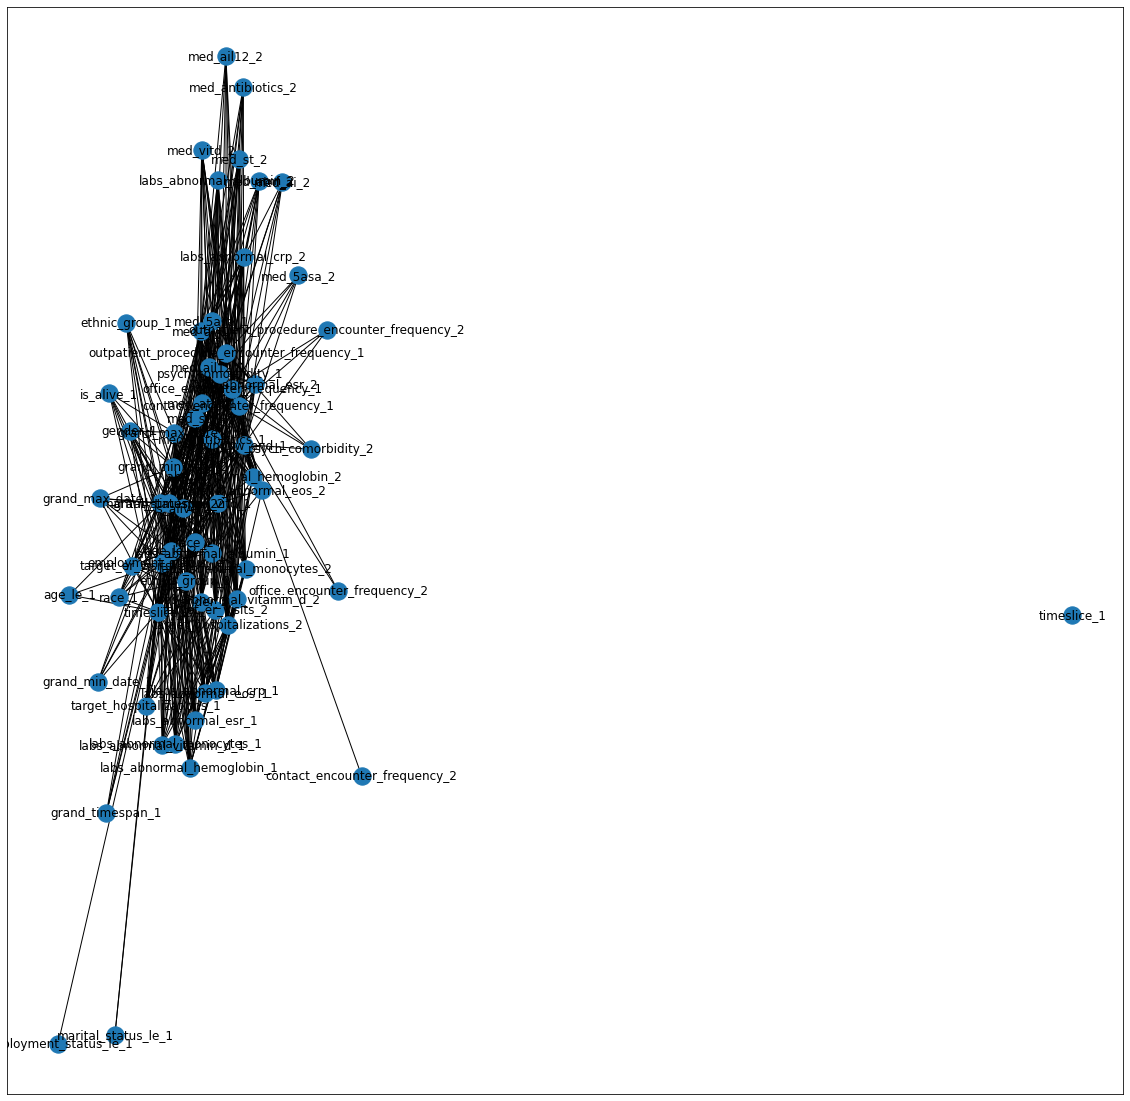

In [20]:
#nx.draw_networkx(G, with_labels=True)
plt.figure(figsize=(20, 20))
nx.draw_networkx(G)

In [21]:
def train_predict_with_model(model, X, y):
    model.fit(X, y)
    kf = KFold(n_splits=10, random_state=1, shuffle=True)
    scores = cross_val_score(model, X, y, cv=kf)
    return scores.mean()

In [22]:
def train_predict_ann(X, y):
    model = Sequential()
    model.add(Dense(12, input_dim=len(X.columns), activation='relu'))
    model.add(Dense(8, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.fit(X, y, epochs=10, batch_size=10)
    return model.evaluate(X, y)


In [23]:
def eval_models(start_timeslice, predictors, response, key, show_rankings = False, train_ann = False):
    X = df.sort_values(key).query('timeslice == ' + str(start_timeslice))[
        predictors
    ]

    y = df.sort_values(key).query('timeslice == ' + str((start_timeslice + 1)))[response]
    
    match_df = pd.merge(X, y, how='inner', left_on=key, right_on=key)
    
    
    X = match_df[predictors].drop([key], axis=1)
    y = match_df[response].drop([key], axis=1).iloc[:, 0]
    #y2 = match_df['target_er_visits']
    
    
    models = {
        #"NB" : GaussianNB(), 
        "kNN" : KNeighborsClassifier(n_neighbors=3), 
        "SVM" : svm.SVC(kernel='linear'),
        "RF" : RandomForestClassifier(random_state=1, max_depth=10)
    }
        
    print("Starting timeslice: ", start_timeslice)
    print("Patients used in training models: ", match_df.shape[0])
    for key, model in models.items():
        
        
        
        score = train_predict_with_model(model, X, y)
        print("\t" + key + ": ", score)
        print("\t--------------------")
        
        if key == "RF" and show_rankings:
            features = X.columns
            importances = model.feature_importances_
            indices = np.argsort(importances)[-10:]  # top features
            plt.title('Feature Importances')
            plt.barh(range(len(indices)), importances[indices], color='b', align='center')
            plt.yticks(range(len(indices)), [features[i] for i in indices])
            plt.xlabel('Relative Importance')
            plt.show()
            
            rfe = RFE(model, 10)
            fit = rfe.fit(X, y)
            #print("Num Features:",  fit.n_features_)
            #print("Selected Features: ", fit.support_)
            #print("Feature Ranking: ",  fit.ranking_)
            features = str(fit.ranking_).replace('\n', '').replace('[', '').replace(']', '').replace('  ', ' ').split(' ')[1:]
            #print(features)
            for i in range(0, len(features)):
                if int(features[i]) == 1:
                    print(X.columns[i])
    if train_ann:        
        ann = train_predict_ann(X, y)
        print("ANN: ", ann)
        
    print("_________________________________________________")

In [28]:
predictors = ['project_patient_id','contact_encounter_frequency', 'office_encounter_frequency',
       'outpatient_procedure_encounter_frequency', 'psych_comorbidity',
       'med_5asa', 'med_ai', 'med_ail12', 'med_antibiotics', 'med_atnf',
       'med_st', 'med_vitd', 'labs_abnormal_albumin', 'labs_abnormal_crp',
       'labs_abnormal_eos', 'labs_abnormal_esr', 'labs_abnormal_hemoglobin',
       'labs_abnormal_monocytes', 'labs_abnormal_vitamin_d', 'gender', 'race',
       'ethnic_group', 'age_le', 'marital_status_le', 'employment_status_le', 'target_er_visits']

response = ['project_patient_id','target_hospitalizations'] #'target_er_visits'
key = 'project_patient_id'

Starting timeslice:  1
Patients used in training models:  1625
	kNN:  0.7600015148072408
	--------------------
	SVM:  0.7760130273422707
	--------------------
	RF:  0.7784670150723321
	--------------------


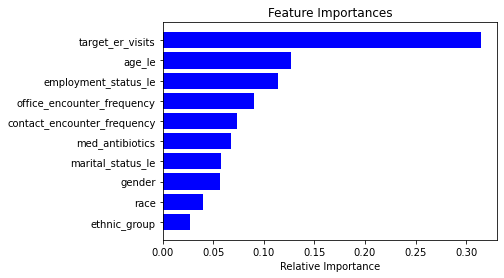

/Users/dmitriyb/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:67: FutureWarning:

Pass n_features_to_select=10 as keyword args. From version 0.25 passing these as positional arguments will result in an error



contact_encounter_frequency
office_encounter_frequency
psych_comorbidity
med_antibiotics
gender
race
age_le
marital_status_le
employment_status_le
target_er_visits
_________________________________________________


In [29]:
for i in range(1, 2):
    eval_models(i, predictors, response, key, True, False)

In [31]:
predictors = ['project_patient_id','contact_encounter_frequency', 'office_encounter_frequency',
       'psych_comorbidity','med_antibiotics', 'gender', 'race',
       'age_le', 'employment_status_le','target_er_visits']

response = ['project_patient_id','target_hospitalizations'] #'target_er_visits'
key = 'project_patient_id'

Starting timeslice:  1
Patients used in training models:  1625
	kNN:  0.7556881011891237
	--------------------
	SVM:  0.7766303112928881
	--------------------
	RF:  0.7655457093084905
	--------------------


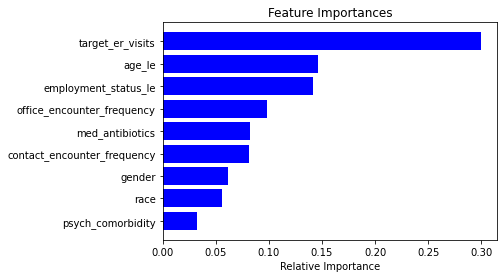

/Users/dmitriyb/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:67: FutureWarning:

Pass n_features_to_select=10 as keyword args. From version 0.25 passing these as positional arguments will result in an error



contact_encounter_frequency
office_encounter_frequency
psych_comorbidity
med_antibiotics
gender
race
age_le
employment_status_le
_________________________________________________
Starting timeslice:  2
Patients used in training models:  1625
	kNN:  0.7236953722638795
	--------------------
	SVM:  0.756937817162766
	--------------------
	RF:  0.7341399681890479
	--------------------


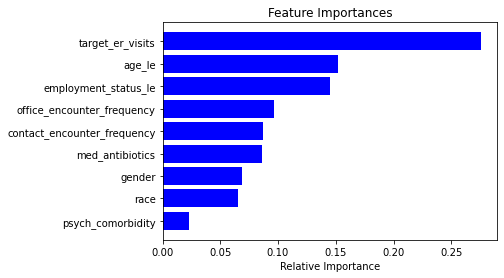

/Users/dmitriyb/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:67: FutureWarning:

Pass n_features_to_select=10 as keyword args. From version 0.25 passing these as positional arguments will result in an error



contact_encounter_frequency
office_encounter_frequency
psych_comorbidity
med_antibiotics
gender
race
age_le
employment_status_le
_________________________________________________
Starting timeslice:  3
Patients used in training models:  1357
	kNN:  0.7229248366013072
	--------------------
	SVM:  0.7561165577342048
	--------------------
	RF:  0.7428322440087145
	--------------------


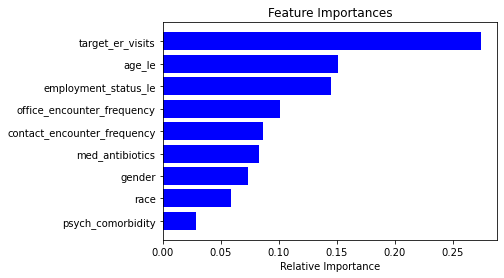

/Users/dmitriyb/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:67: FutureWarning:

Pass n_features_to_select=10 as keyword args. From version 0.25 passing these as positional arguments will result in an error



contact_encounter_frequency
office_encounter_frequency
psych_comorbidity
med_antibiotics
gender
race
age_le
employment_status_le
_________________________________________________
Starting timeslice:  4
Patients used in training models:  1106
	kNN:  0.7089352989352989
	--------------------
	SVM:  0.7541850941850943
	--------------------
	RF:  0.7306715806715807
	--------------------


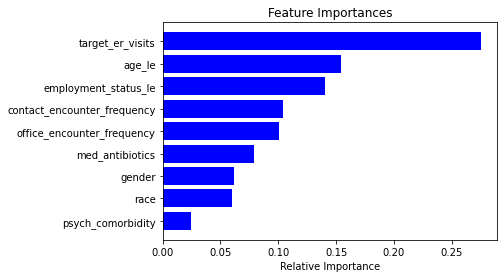

/Users/dmitriyb/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:67: FutureWarning:

Pass n_features_to_select=10 as keyword args. From version 0.25 passing these as positional arguments will result in an error



contact_encounter_frequency
office_encounter_frequency
psych_comorbidity
med_antibiotics
gender
race
age_le
employment_status_le
_________________________________________________
Starting timeslice:  5
Patients used in training models:  882
	kNN:  0.725638406537283
	--------------------
	SVM:  0.756281920326864
	--------------------
	RF:  0.7335929519918285
	--------------------


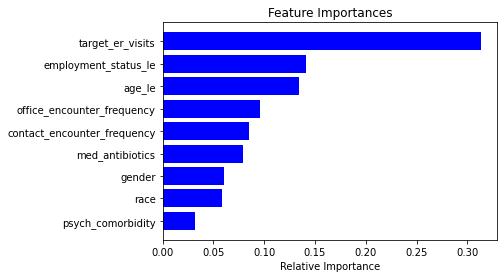

contact_encounter_frequency
office_encounter_frequency
psych_comorbidity
med_antibiotics
gender
race
age_le
employment_status_le
_________________________________________________


/Users/dmitriyb/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:67: FutureWarning:

Pass n_features_to_select=10 as keyword args. From version 0.25 passing these as positional arguments will result in an error



In [32]:
for i in range(1, 6):
    eval_models(i, predictors, response, key, True, False)

In [33]:
# https://plotly.com/python/sankey-diagram/

In [34]:
import plotly.graph_objects as go
import urllib, json

In [35]:
fig = go.Figure(data=[go.Sankey(
    node = dict(
      pad = 15,
      thickness = 20,
      line = dict(color = "black", width = 0.5),
      label = ["A1", "A2", "B1", "B2", "C1", "C2"],
      color = "blue"
    ),
    link = dict(
      source = [0, 1, 0, 2, 3, 3], # indices correspond to labels, eg A1, A2, A1, B1, ...
      target = [2, 3, 3, 4, 4, 5],
      value = [8, 4, 2, 8, 4, 2]
  ))])

fig.update_layout(title_text="Basic Sankey Diagram", font_size=10)
fig.show()

In [36]:
df.head()

,Unnamed: 0,project_patient_id,window_id,window_start,window_train_breakpoint,window_end,contact_encounter_frequency,office_encounter_frequency,outpatient_procedure_encounter_frequency,psych_comorbidity,...,race,ethnic_group,is_alive,grand_max_date,grand_min_date,grand_timespan,age_le,marital_status_le,employment_status_le,timeslice
0,0,4d3ea8f4-15b6-477f-805e-7932c6aabc74,0,2014-06-15 18:00:00,2015-06-16 00:00:00,2015-06-16 00:00:00,2.0,2.0,0.0,0.0,...,-1,-1,0,2015-06-16 00:00:00,2011-04-05 00:00:00,1533 days,1,3,6,3
1,1,4d3ea8f4-15b6-477f-805e-7932c6aabc74,1,2013-06-15 12:00:00,2014-06-15 18:00:00,2014-06-15 18:00:00,2.0,2.0,0.0,0.0,...,-1,-1,0,2015-06-16 00:00:00,2011-04-05 00:00:00,1533 days,1,3,6,2
2,2,4d3ea8f4-15b6-477f-805e-7932c6aabc74,2,2012-06-15 06:00:00,2013-06-15 12:00:00,2013-06-15 12:00:00,2.0,0.0,0.0,0.0,...,-1,-1,0,2015-06-16 00:00:00,2011-04-05 00:00:00,1533 days,1,3,6,1
3,3,dba8cd2e-1a6c-49a3-8d84-e95c58edf52d,0,2016-05-26 18:00:00,2017-05-27 00:00:00,2017-05-27 00:00:00,0.0,0.0,0.0,0.0,...,-1,-1,0,2017-05-27 00:00:00,2009-06-26 00:00:00,2892 days,3,3,6,6
4,4,dba8cd2e-1a6c-49a3-8d84-e95c58edf52d,1,2015-05-27 12:00:00,2016-05-26 18:00:00,2016-05-26 18:00:00,0.0,0.0,0.0,0.0,...,-1,-1,0,2017-05-27 00:00:00,2009-06-26 00:00:00,2892 days,3,3,6,5


In [5]:
url = 'https://raw.githubusercontent.com/plotly/plotly.js/master/test/image/mocks/sankey_energy.json'
response = urllib.request.urlopen(url)
data = json.loads(response.read())



In [7]:
data

{'data': [{'type': 'sankey',
   'domain': {'x': [0, 1], 'y': [0, 1]},
   'orientation': 'h',
   'valueformat': '.0f',
   'valuesuffix': 'TWh',
   'node': {'pad': 15,
    'thickness': 15,
    'line': {'color': 'black', 'width': 0.5},
    'label': ["Agricultural 'waste'",
     'Bio-conversion',
     'Liquid',
     'Losses',
     'Solid',
     'Gas',
     'Biofuel imports',
     'Biomass imports',
     'Coal imports',
     'Coal',
     'Coal reserves',
     'District heating',
     'Industry',
     'Heating and cooling - commercial',
     'Heating and cooling - homes',
     'Electricity grid',
     'Over generation / exports',
     'H2 conversion',
     'Road transport',
     'Agriculture',
     'Rail transport',
     'Lighting & appliances - commercial',
     'Lighting & appliances - homes',
     'Gas imports',
     'Ngas',
     'Gas reserves',
     'Thermal generation',
     'Geothermal',
     'H2',
     'Hydro',
     'International shipping',
     'Domestic aviation',
     'Internation

In [ ]:
# override gray link colors with 'source' colors
opacity = 0.4
# change 'magenta' to its 'rgba' value to add opacity
data['data'][0]['node']['color'] = ['rgba(255,0,255, 0.8)' if color == "magenta" else color for color in data['data'][0]['node']['color']]
data['data'][0]['link']['color'] = [data['data'][0]['node']['color'][src].replace("0.8", str(opacity))
                                    for src in data['data'][0]['link']['source']]

fig = go.Figure(data=[go.Sankey(
    valueformat = ".0f",
    valuesuffix = "TWh",
    # Define nodes
    node = dict(
      pad = 15,
      thickness = 15,
      line = dict(color = "black", width = 0.5),
      label =  data['data'][0]['node']['label'],
      color =  data['data'][0]['node']['color']
    ),
    # Add links
    link = dict(
      source =  data['data'][0]['link']['source'],
      target =  data['data'][0]['link']['target'],
      value =  data['data'][0]['link']['value'],
      label =  data['data'][0]['link']['label'],
      color =  data['data'][0]['link']['color']
))])

fig.update_layout(title_text="Energy forecast for 2050<br>Source: Department of Energy & Climate Change, Tom Counsell via <a href='https://bost.ocks.org/mike/sankey/'>Mike Bostock</a>",
                  font_size=10)
fig.show()